# Data Preprocessing

In [1]:
# imports
from datasets import load_dataset
from transformers import BertTokenizer
import tensorflow as tf
from transformers import DataCollatorWithPadding

/mnt/d/Github/IMDB_Sentimental_Analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-17 17:48:41.997713: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 17:48:48.064506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-17 17:48:48.072554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-

In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
# load the data
dataset = load_dataset("imdb",cache_dir="../data/hf_cache")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [5]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# tokenize the data
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
# Saving the tokenizer
tokenizer.save_pretrained("../outputs/models/bert-base-uncased_tokenizer")

('../outputs/models/bert-base-uncased_tokenizer/tokenizer_config.json',
 '../outputs/models/bert-base-uncased_tokenizer/special_tokens_map.json',
 '../outputs/models/bert-base-uncased_tokenizer/vocab.txt',
 '../outputs/models/bert-base-uncased_tokenizer/added_tokens.json')

In [6]:
# Tokenize the datasets

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 25000/25000 [00:37<00:00, 672.64 examples/s]


In [7]:
print(train_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [9]:
# Convert HuggingFace datasets to TensorFlow datasets using .to_tf_dataset()

# Create a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to TensorFlow datasets
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)

tf_test_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator
)

In [10]:
print(tf_train_dataset)

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Model Training

In [11]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [12]:
# Load the BERT model for sequence classification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Compile the model
optimizer = Adam(learning_rate=2e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
metrics = SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model

history = model.fit(
    tf_train_dataset,
    validation_data=tf_test_dataset,
    epochs=3,
    batch_size=16,
)

# Save the model
model.save_pretrained("../outputs/models/bert-imdb-hf")

2025-05-17 17:51:24.315876: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2025-05-17 17:51:47.033428: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa74621c600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-17 17:51:47.033466: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-17 17:51:47.130674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-17 17:51:47.237959: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1747484507.335468    1718 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 692s 214ms/step - loss: 0.3315 - accuracy: 0.8517 - val_loss: 0.3053 - val_accuracy: 0.8676
Epoch 2/3
3125/3125 [==============================] - 626s 200ms/step - loss: 0.1896 - accuracy: 0.9270 - val_loss: 0.2939 - val_accuracy: 0.8809
Epoch 3/3
3125/3125 [==============================] - 621s 199ms/step - loss: 0.0963 - accuracy: 0.9657 - val_loss: 0.3924 - val_accuracy: 0.8839


## Metrics

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_logits= model.predict(tf_test_dataset)
y_pred = np.argmax(y_pred_logits.logits, axis=1)

y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

# Reports
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))
print(confusion_matrix(y_true, y_pred))


3125/3125 [==============================] - 165s 52ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88     12500
    Positive       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

[[11121  1379]
 [ 1523 10977]]


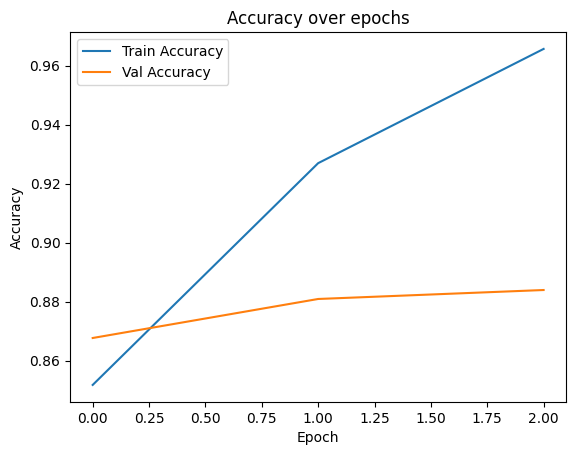

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    output = model(inputs)
    prediction = tf.argmax(output.logits, axis=1).numpy()[0]
    return "Positive" if prediction == 1 else "Negative"

predict_sentiment("This movie was amazing and the acting was superb!")


'Positive'